In [1]:
import numpy as np
import sys, os
%matplotlib notebook
import matplotlib.pyplot as plt
sys.path.append(os.environ['raco'])
sys.path.append(os.environ['rapl'])
sys.path.append(os.environ['rapp'])
from rayleigh_diagnostics import Shell_Slices
from common import *
import spectral_utils as su

In [2]:
dirname = '.'
datadir = dirname + '/data/'
the_file = get_widest_range_file(datadir, 'AZ_Avgs')
print ('reading ' + the_file)
di = get_dict(the_file)
vals = di['vals']
lut = di['lut']
np.shape(vals)

reading ./data/AZ_Avgs-13652500_27350000.pkl


(384, 192, 294)

In [3]:
gi = get_grid_info(dirname)
rr = gi['rr']
nr = len(rr)
nphi = gi['nphi']
tw = gi['tw']
tw_2d = gi['tw_2d']
nt = len(tw)
tt_lat = gi['tt_lat']
print('nr =', nr)
print('nt =', nt)
print('nphi =', nphi)

nr = 192
nt = 384
nphi = 768


In [4]:
# indices associated with shell slices
a0 = Shell_Slices('16150000')
rinds = a0.rad_inds
print (rr[rinds]/rsun)

[0.71656272 0.70707956 0.6906394  0.66109085 0.63447754 0.6034544
 0.57752866 0.5476774  0.51833426 0.50226305]


<IPython.core.display.Javascript object>


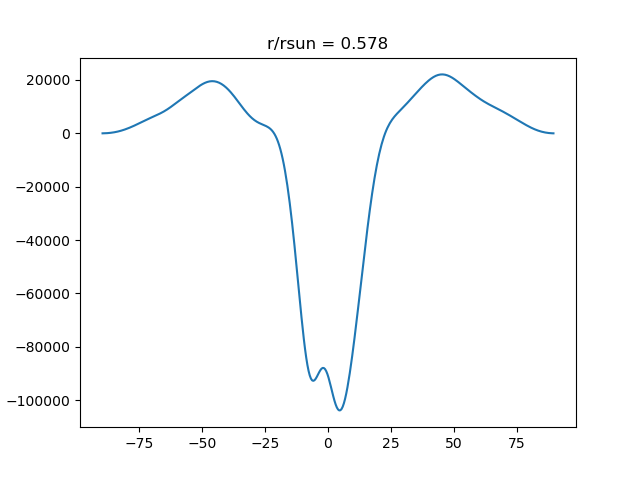

Text(0.5, 1.0, 'r/rsun = 0.578')

In [5]:
# magnetic torque
ir0 = 6

torque_mm = vals[:, :, lut[1805]]
torque_ms = vals[:, :, lut[1806]]
torque_tot = torque_ms + torque_mm 
plt.figure()
plt.plot(tt_lat, torque_tot[:, rinds[ir0]])
plt.title('r/rsun = %.3f' %(rr[rinds[ir0]]/rsun))

In [6]:
# read in time m spectra from shell slices
print ('reading')

di_tspec = get_dict(get_widest_range_file(datadir + '/tmspec/', 'tmspec_qval3306_irval%02i' %ir0))
mvals = di_tspec['mvals']
freq = di_tspec['freq']
bphi_dr = di_tspec['vals']

print ('reading')
bphi_dt = get_dict(get_widest_range_file(datadir + '/tmspec/', 'tmspec_qval3308_irval%02i' %ir0))['vals']

print ('reading')
br = get_dict(get_widest_range_file(datadir + '/tmspec/','tmspec_qval0801_irval%02i' %ir0))['vals']
print ('reading')
bt = get_dict(get_widest_range_file(datadir + '/tmspec/','tmspec_qval0802_irval%02i' %ir0))['vals']

print (np.shape(bt))

reading
reading
reading
reading
(13700, 256, 384)


In [7]:
# get the torque by summing over frequency and m
ntimes, nm, nt = np.shape(bt)
def summ(arr):
    return arr[0,...] + 2*np.sum(arr[1:,...],axis=0)
torque_spec = np.real(np.conjugate(br)*bphi_dr + np.conjugate(bt)*bphi_dt)/9/(ntimes*nm)**2
torque_spec_tot = summ(np.sum(torque_spec,axis=0))

<IPython.core.display.Javascript object>


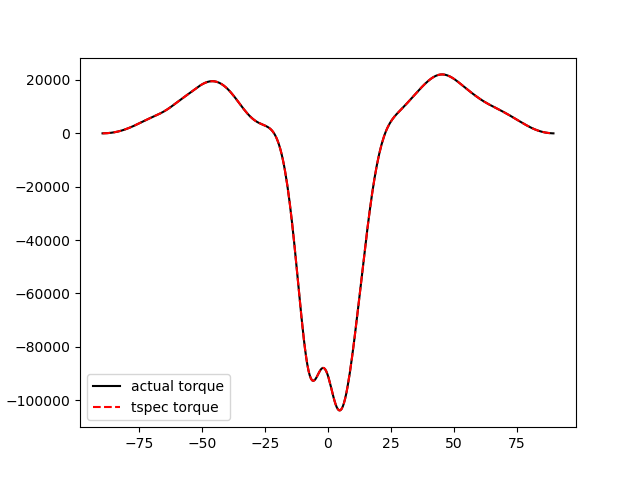

In [8]:
plt.figure()
plt.plot(tt_lat, torque_tot[:, rinds[ir0]], 'k', label='actual torque')
plt.plot(tt_lat, torque_spec_tot, 'r--', label='tspec torque')
plt.legend()

In [9]:
# nice! Now figure out how much torque comes from different m modes
# "prod[1:nfreq, 1:nm, 1:ntheta]" represents the torque at theta coming from different
# freq, m components

In [10]:
#lat0 = 0.
#ith0 = np.argmin(np.abs(tt_lat - lat0))
#tau_tot0 = tau_tot[ith0, rinds[ir0]]
torque_spec_m = np.sum(torque_spec, axis=0)
torque_spec_m[1:, :] *= 2
torque_spec_freq = np.zeros((ntimes, nt))
for ifreq in range(ntimes):
    torque_spec_freq[ifreq, ...] = summ(torque_spec[ifreq, ...])

In [11]:
print (np.shape(torque_spec_m))
print (np.shape(torque_spec_freq))

(256, 384)
(13700, 384)


In [12]:
# get the total torque to "normalize" things by
torque_tot_nd = torque_tot[:, rinds[ir0]].reshape((1, nt))

In [13]:
# OK, now plot the torque contributions from low m
# check normalizations first
print (np.mean(np.sum(torque_spec_m/torque_tot_nd, axis=0)))
print (np.std(np.sum(torque_spec_m/torque_tot_nd, axis=0)))
print (np.mean(np.sum(torque_spec_freq/torque_tot_nd, axis=0)))
print (np.std(np.sum(torque_spec_freq/torque_tot_nd, axis=0)))

1.0009274388717575
0.017432714829068684
1.0009274388717733
0.017432714829380278


In [14]:
#OK good
print (np.shape(torque_tot_nd))

(1, 384)


In [15]:
# plot stuff
sys.path.append(os.environ['rapl'] + '/slice')
from slice_util import spec_2D_fig_dimensions
from plotcommon import *

kw_my_pcolormesh = dotdict(dict(my_pcolormesh_kwargs_default))
#kw_my_pcolormesh['logscale'] = False
#kw_my_pcolormesh['posdef'] = False

kw_make_figure = dotdict(dict(make_figure_kwargs_default))
spec_2D_fig_dimensions['sub_margin_top_inches'] = 3/4
kw_make_figure.update(spec_2D_fig_dimensions)

<IPython.core.display.Javascript object>


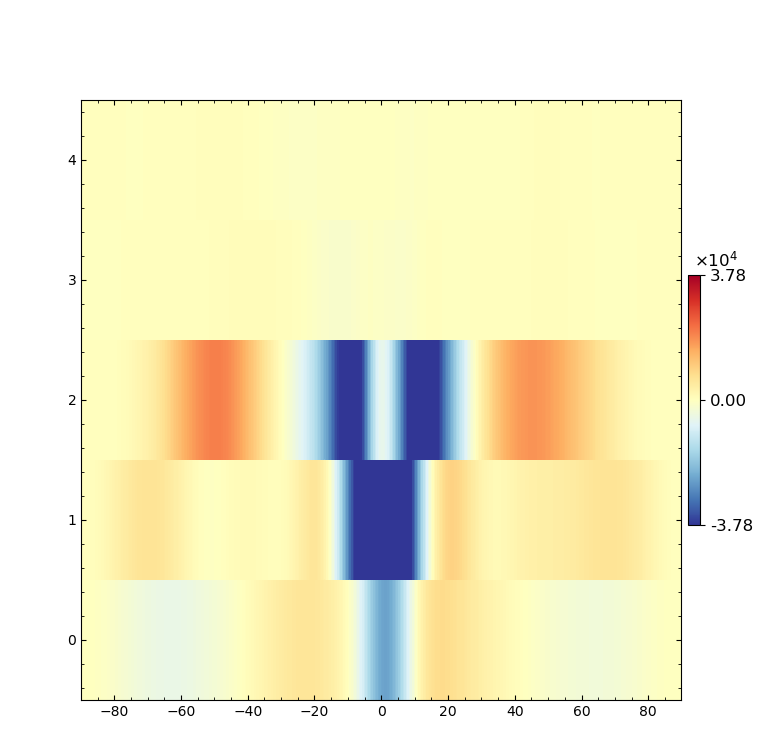

In [16]:
# plot torque fraction distributed across m and lat.
fig, axs, fpar = make_figure(**kw_make_figure)
ax = axs[0, 0]
kw_my_pcolormesh.cbar_pos = 'right'
kw_my_pcolormesh.x = tt_lat
kw_my_pcolormesh.y = mvals
kw_my_pcolormesh.ymax = 4
mmin, mmax = my_pcolormesh((torque_spec_m).T, fig, ax, **kw_my_pcolormesh)

<IPython.core.display.Javascript object>


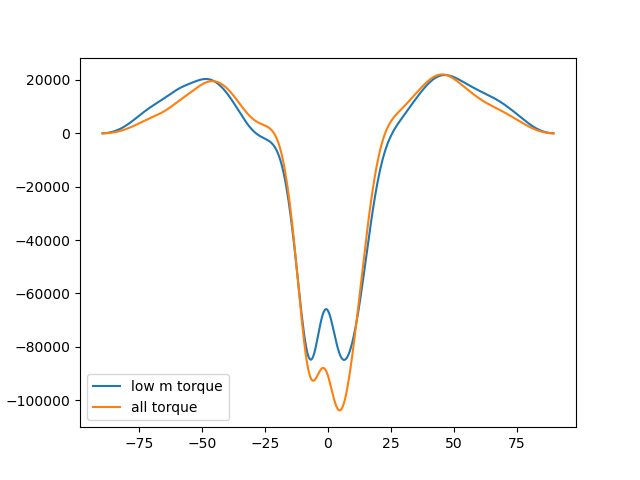

In [17]:
# wow m = 0, 1, 2 really seems like almost all the torque let's see if that's true
mmin = 1
mmax = 2
plt.figure()
plt.plot(tt_lat, np.sum(torque_spec_m[mmin:mmax+1,:], axis=0), label='low m torque')
plt.plot(tt_lat, torque_tot[:, rinds[ir0]], label='all torque')
plt.legend()

In [18]:
# yep that's really true... also super useful!

In [19]:
# now let's do this for frequency

<IPython.core.display.Javascript object>


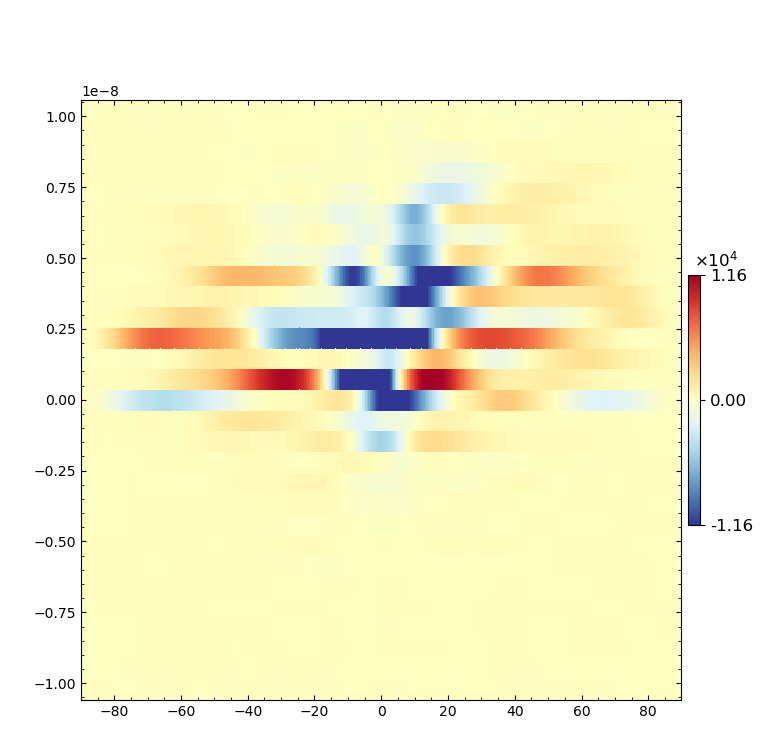

In [20]:
# plot torque fraction distributed across freq and lat.
fig, axs, fpar = make_figure(**kw_make_figure)
ax = axs[0, 0]
kw_my_pcolormesh.cbar_pos = 'right'
kw_my_pcolormesh.x = tt_lat
kw_my_pcolormesh.y = freq
kw_my_pcolormesh.ymin = -1e-8
kw_my_pcolormesh.ymax = 1e-8
mmin, mmax = my_pcolormesh((torque_spec_freq).T, fig, ax, **kw_my_pcolormesh)

In [21]:
# compute the differential rotation
diffrot = vals[:, :, lut[3]]/gi['xx']/(2*np.pi)*1e9

<IPython.core.display.Javascript object>


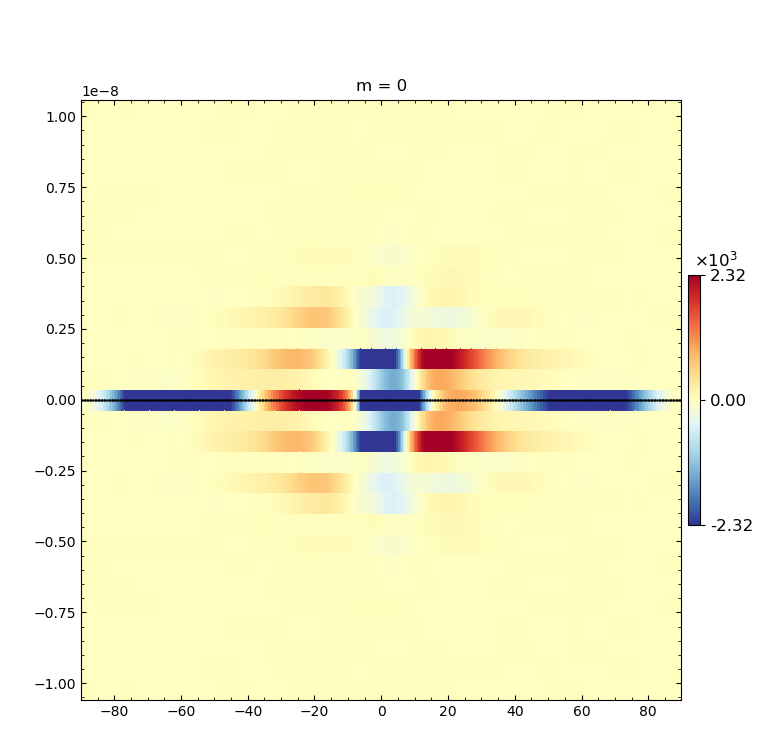

Text(0.5, 1.0, 'm = 0')

In [22]:
# plot torque fraction distributed across freq and lat.
mchoose = 0
fig, axs, fpar = make_figure(**kw_make_figure)
ax = axs[0, 0]
kw_my_pcolormesh.cbar_pos = 'right'
kw_my_pcolormesh.x = tt_lat
kw_my_pcolormesh.y = freq
kw_my_pcolormesh.ymin = -1e-8
kw_my_pcolormesh.ymax = 1e-8
mmin, mmax = my_pcolormesh((torque_spec[:, mchoose, :]).T, fig, ax, **kw_my_pcolormesh)

ax.scatter(tt_lat, -diffrot[:, rinds[ir0]]*1e-9*mchoose, color='k', s=.5)

plt.title('m = %i' %mchoose)

<IPython.core.display.Javascript object>


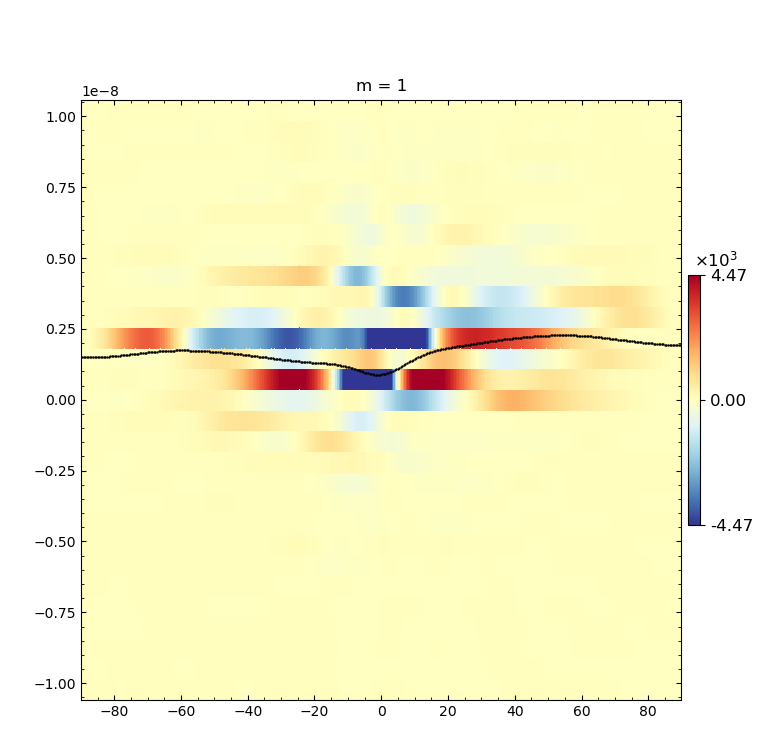

Text(0.5, 1.0, 'm = 1')

In [23]:
# plot torque fraction distributed across freq and lat.
mchoose = 1
fig, axs, fpar = make_figure(**kw_make_figure)
ax = axs[0, 0]
kw_my_pcolormesh.cbar_pos = 'right'
kw_my_pcolormesh.x = tt_lat
kw_my_pcolormesh.y = freq
kw_my_pcolormesh.ymin = -1e-8
kw_my_pcolormesh.ymax = 1e-8
mmin, mmax = my_pcolormesh((torque_spec[:, mchoose, :]).T, fig, ax, **kw_my_pcolormesh)

ax.scatter(tt_lat, -diffrot[:, rinds[ir0]]*1e-9*mchoose, color='k', s=.5)

plt.title('m = %i' %mchoose)

<IPython.core.display.Javascript object>


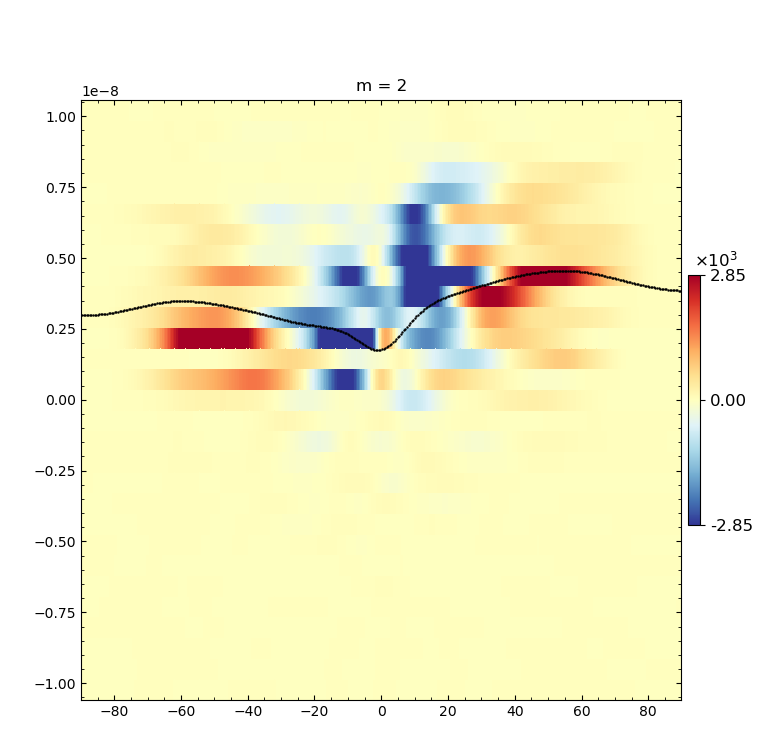

Text(0.5, 1.0, 'm = 2')

In [24]:
# plot torque fraction distributed across freq and lat.
mchoose = 2
fig, axs, fpar = make_figure(**kw_make_figure)
ax = axs[0, 0]
kw_my_pcolormesh.cbar_pos = 'right'
kw_my_pcolormesh.x = tt_lat
kw_my_pcolormesh.y = freq
kw_my_pcolormesh.ymin = -1e-8
kw_my_pcolormesh.ymax = 1e-8
mmin, mmax = my_pcolormesh((torque_spec[:, mchoose, :]).T, fig, ax, **kw_my_pcolormesh)

ax.scatter(tt_lat, -diffrot[:, rinds[ir0]]*1e-9*mchoose, color='k', s=.5)

plt.title('m = %i' %mchoose)

<IPython.core.display.Javascript object>


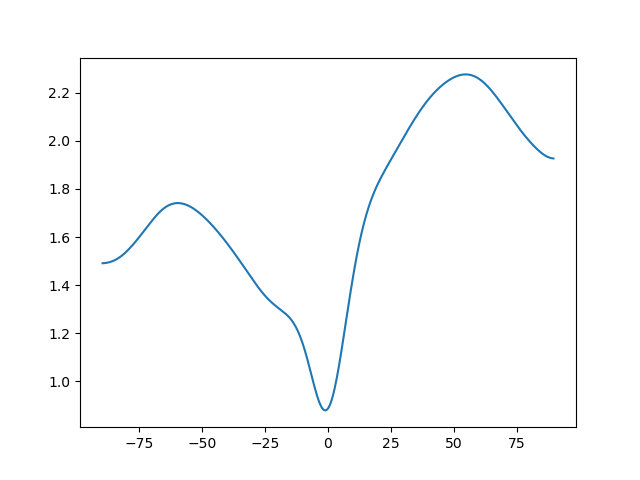

In [25]:
# hmmm... this is a bit less well confined
# still, check how much power is in the frequency band advect with diffrot
plt.figure()
plt.plot(tt_lat, -diffrot[:, rinds[ir0]])

<IPython.core.display.Javascript object>


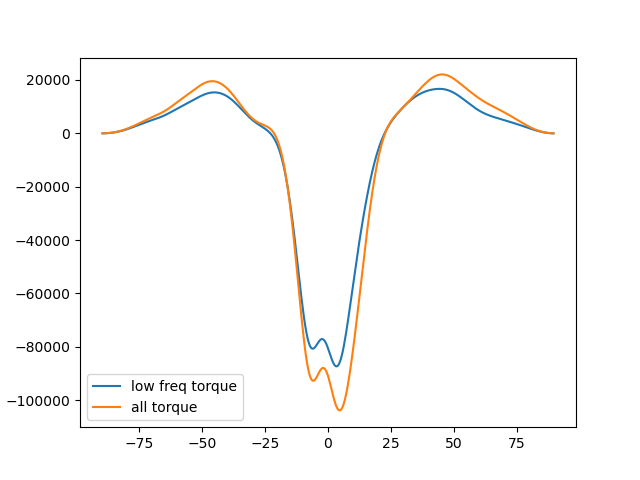

In [26]:
# frequency band 0 to 2.2*2 = 4.5 nHz
fmin = 0 
fmax = 4.5e-9
ifmin = np.argmin(np.abs(freq - fmin))
ifmax = np.argmin(np.abs(freq - fmax))

# wow m = 0, 1, 2 really seems like almost all the torque let's see if that's true
mcut = 2
plt.figure()
plt.plot(tt_lat, np.sum(torque_spec_freq[ifmin:ifmax+1, :], axis=0), label='low freq torque')
plt.plot(tt_lat, torque_tot[:, rinds[ir0]], label='all torque')
plt.legend()

In [27]:
# pretty good...but it's not exactly at one frequency

In [28]:
# might require clearer picture...look at whole sim

In [29]:
# UPDATE 02/20/22: Look at some stuff as functions of time. See if cycling field is caused by induction

the_file = get_widest_range_file(datadir + '/mtrace/', 'mtrace_qval0802_irval%02i' %ir0)
print ('reading', the_file)
di_mtrace = get_dict(the_file)

reading ./data//mtrace/mtrace_qval0802_irval06-13651000_27350000.pkl


In [30]:
di_mtrace.keys()

dict_keys(['vals', 'times', 'iters', 'mvals'])

In [31]:
bt_mtrace = di_mtrace['vals']
times = di_mtrace['times']
prot = compute_Prot('.')

In [32]:
# also read in induction of btheta
the_file = get_widest_range_file(datadir + '/mtrace/', 'mtrace_qval3011_irval%02i' %ir0)
print ('reading', the_file)
di_mtrace = get_dict(the_file)
compt_mtrace = di_mtrace['vals']

reading ./data//mtrace/mtrace_qval3011_irval06-13651000_27350000.pkl


In [33]:
the_file = get_widest_range_file(datadir + '/mtrace/', 'mtrace_qval3005_irval%02i' %ir0)
print ('reading', the_file)
di_mtrace = get_dict(the_file)
sheart_mtrace = di_mtrace['vals']

reading ./data//mtrace/mtrace_qval3005_irval06-13651000_27350000.pkl


In [44]:
the_file = get_widest_range_file(datadir + '/mtrace/', 'mtrace_qval0301_irval%02i' %ir0)
print ('reading', the_file)
di_mtrace = get_dict(the_file)
omr_mtrace = di_mtrace['vals']

reading ./data//mtrace/mtrace_qval0301_irval06-13651000_27350000.pkl


In [34]:
np.shape(bt_mtrace)

(13700, 256, 384)

In [40]:
lat0 = 20
ilat0 = np.argmin(np.abs(tt_lat - lat0))
mchoose = 2
t = times/prot

<IPython.core.display.Javascript object>


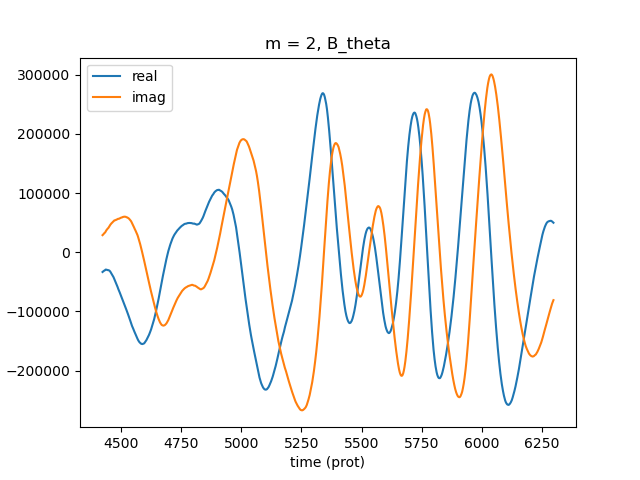

Text(0.5, 1.0, 'm = 2, B_theta')

In [41]:
plt.figure()
plt.plot(t, np.real(bt_mtrace[:, mchoose, ilat0]), label='real')
plt.plot(t, np.imag(bt_mtrace[:, mchoose, ilat0]), label='imag')
plt.xlabel('time (prot)')
plt.legend()
plt.title('m = %i, B_theta' %mchoose)

<IPython.core.display.Javascript object>


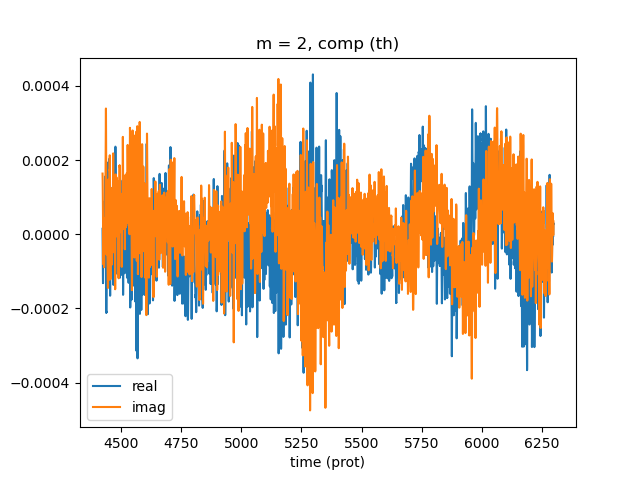

Text(0.5, 1.0, 'm = 2, comp (th)')

In [42]:
plt.figure()
plt.plot(t, np.real(compt_mtrace[:, mchoose, ilat0]), label='real')
plt.plot(t, np.imag(compt_mtrace[:, mchoose, ilat0]), label='imag')
plt.xlabel('time (prot)')
plt.legend()
plt.title('m = %i, comp (th)' %mchoose)

<IPython.core.display.Javascript object>


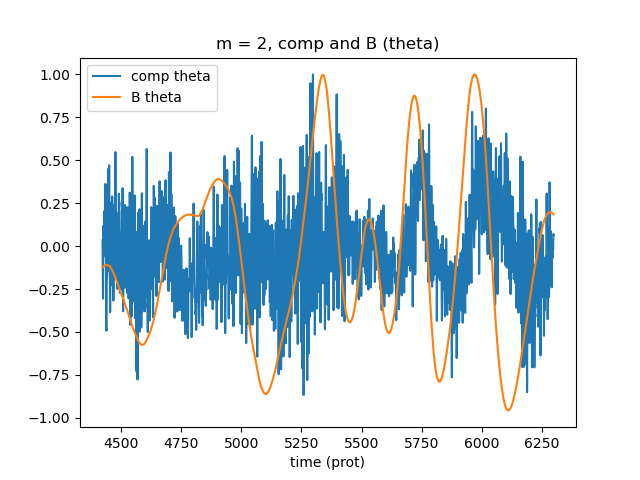

Text(0.5, 1.0, 'm = 2, comp and B (theta)')

In [43]:
plt.figure()
norm = np.max(np.real(compt_mtrace[:, mchoose, ilat0]))
plt.plot(t, np.real(compt_mtrace[:, mchoose, ilat0])/norm, label='comp theta')

norm = np.max(np.real(bt_mtrace[:, mchoose, ilat0]))
plt.plot(t, np.real(bt_mtrace[:, mchoose, ilat0])/norm, label='B theta')

plt.xlabel('time (prot)')
plt.legend()
plt.title('m = %i, comp and B (theta)' %mchoose)

<IPython.core.display.Javascript object>


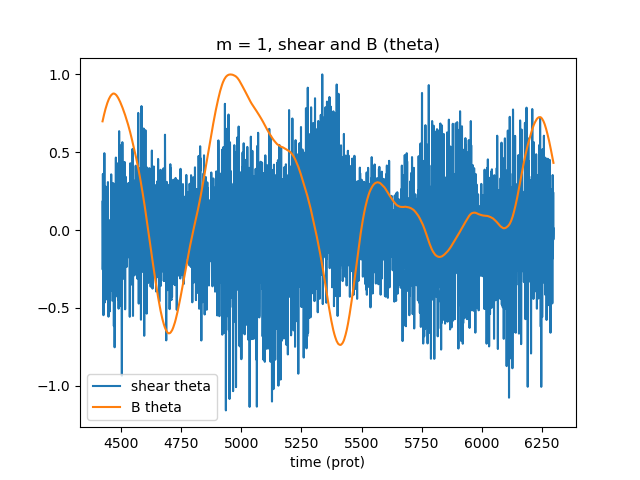

Text(0.5, 1.0, 'm = 1, shear and B (theta)')

In [39]:
plt.figure()
norm = np.max(np.real(sheart_mtrace[:, mchoose, ilat0]))
plt.plot(t, np.real(sheart_mtrace[:, mchoose, ilat0])/norm, label='shear theta')

norm = np.max(np.real(bt_mtrace[:, mchoose, ilat0]))
plt.plot(t, np.real(bt_mtrace[:, mchoose, ilat0])/norm, label='B theta')

plt.xlabel('time (prot)')
plt.legend()
plt.title('m = %i, shear and B (theta)' %mchoose)

<IPython.core.display.Javascript object>


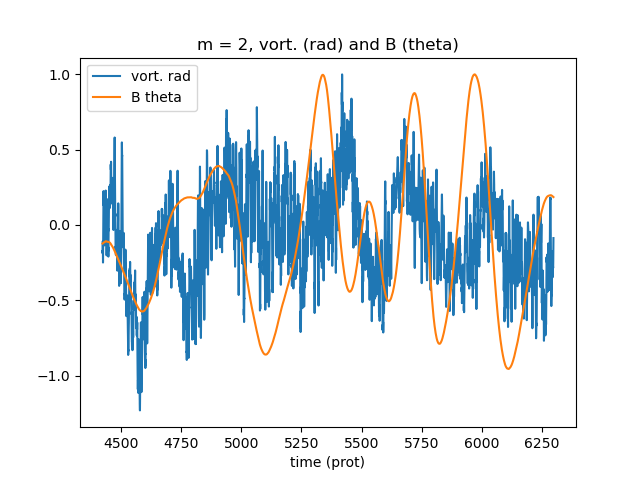

Text(0.5, 1.0, 'm = 2, vort. (rad) and B (theta)')

In [45]:
plt.figure()
norm = np.max(np.real(omr_mtrace[:, mchoose, ilat0]))
plt.plot(t, np.real(omr_mtrace[:, mchoose, ilat0])/norm, label='vort. rad')

norm = np.max(np.real(bt_mtrace[:, mchoose, ilat0]))
plt.plot(t, np.real(bt_mtrace[:, mchoose, ilat0])/norm, label='B theta')

plt.xlabel('time (prot)')
plt.legend()
plt.title('m = %i, vort. (rad) and B (theta)' %mchoose)

In [46]:
# maybe look in terms of energy? 

In [47]:
the_file = get_widest_range_file(datadir + '/mtrace/', 'mtrace_qval0003_irval%02i' %ir0)
print ('reading', the_file)
di_mtrace = get_dict(the_file)
vp_mtrace = di_mtrace['vals']

the_file = get_widest_range_file(datadir + '/mtrace/', 'mtrace_qval0002_irval%02i' %ir0)
print ('reading', the_file)
di_mtrace = get_dict(the_file)
vt_mtrace = di_mtrace['vals']

reading ./data//mtrace/mtrace_qval0003_irval06-13651000_27350000.pkl
reading ./data//mtrace/mtrace_qval0002_irval06-13651000_27350000.pkl


In [53]:
eq = get_eq('.')
rho = eq.rho
rho0 = eq.rho[rinds[ir0]]

In [54]:
ke_hor = 0.5*rho0*np.abs(vt_mtrace**2 + vp_mtrace**2)
me_t = (1/8/np.pi)*np.abs(bt_mtrace**2)

<IPython.core.display.Javascript object>


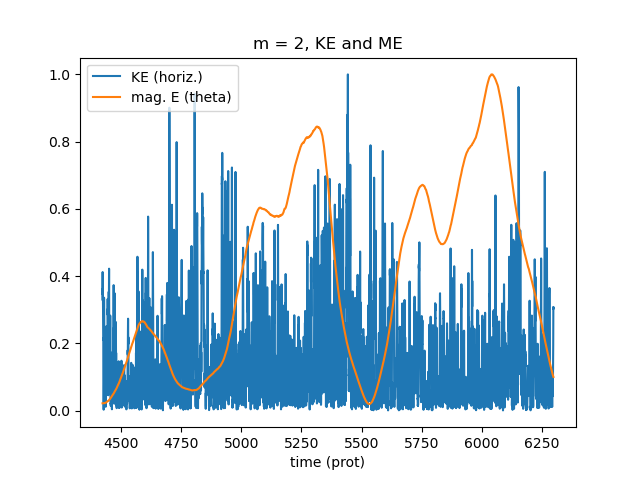

Text(0.5, 1.0, 'm = 2, KE and ME')

In [55]:
plt.figure()
norm = np.max(np.real(ke_hor[:, mchoose, ilat0]))
plt.plot(t, np.real(ke_hor[:, mchoose, ilat0])/norm, label='KE (horiz.)')

norm = np.max(np.real(me_t[:, mchoose, ilat0]))
plt.plot(t, np.real(me_t[:, mchoose, ilat0])/norm, label='mag. E (theta)')

plt.xlabel('time (prot)')
plt.legend()
plt.title('m = %i, KE and ME' %mchoose)

In [56]:
# they're not orders of magnitude different...basically in equipartition
# probably exchanging energy 